In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
sr = 1000
f1 = 4
t1 = np.arange(-500,1200)+500
f2 = 30
t2 = np.arange(-500,1200)+500
f3 = 17
t3 = np.arange(800,2500)+500
f4 = 30
t4 = np.arange(800,2500)+500

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                    sr, \
                    utils.create_decay(len(t1),1,400))
net2, F2_true, _  = utils.make_network(f2, len(t2), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                    sr, \
                    utils.create_decay(len(t2),1,400))
net3, F3_true, _  = utils.make_network(f3, len(t3), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                    sr, \
                    utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1700))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(30,-10,10)]]),\
                    sr, \
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,3000))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) / sr

Text(0, 0.5, 'channel')

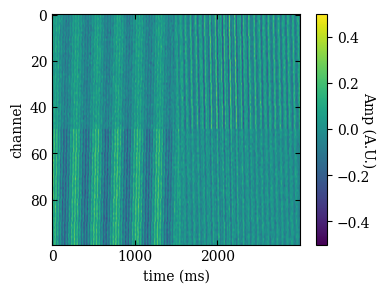

In [3]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(x, aspect='auto', vmin=-0.5, vmax=0.5)
cbar = fig.colorbar(cax)
cbar.set_label('Amp (A.U.)', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('channel')

In [4]:
model_4 = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.92, grad_alpha=0.1, grad_beta=0.1, grad_N=20, sim_thresh_phi_phase=10)
model_4.fit_opt(x, t, sr)

model_2 = nsdmd.NSDMD(opt_rank=2, sim_thresh_phi_amp=0.97, grad_alpha=0.1, grad_beta=0.1, grad_N=20, sim_thresh_phi_phase=10)
model_2.fit_opt(x, t, sr)

#for 2 mode 30 hz guess
model_2_30 = nsdmd.NSDMD(opt_rank=2, sim_thresh_phi_amp=0.97, grad_alpha=0.1, grad_beta=0.1, grad_N=20, sim_thresh_phi_phase=10)
model_2_30.fit_opt(x, t, sr, np.array([30,-30]))

model_6 = nsdmd.NSDMD(opt_rank=6, sim_group_size=2, sim_thresh_phi_amp=0.92, grad_alpha=0.1, grad_beta=0.1, grad_N=20, sim_thresh_phi_phase=10, \
                      feature_f_method='grad', verbose=True)
model_6.fit_opt(x, t, sr)

Starting OPT-DMD...


Text(0, 0.5, 'freq (Hz)')

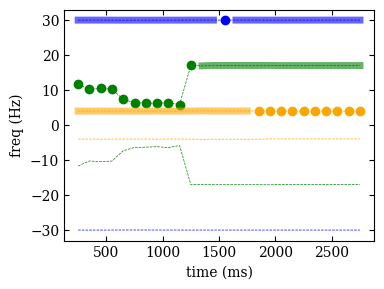

In [5]:
model = model_6 # To plot this model

plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, model.opt_stride/sr, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx)):
    ax.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            ax.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            ax.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
ax.set_xlabel('time (ms)')
ax.set_ylabel('freq (Hz)')

In [6]:
model_4.fit_reduction(x, len(t), sr)
model_2.fit_reduction(x, len(t), sr)
model_2_30.fit_reduction(x, len(t), sr)
model_6.fit_reduction(x, len(t), sr)

Gathering modes...
Found 4 modes
Number of modes: 4/4, stopping at 0
Number of modes: 3/4, stopping at 0
Number of modes: 2/4, stopping at 0
Number of modes: 1/4, stopping at 0


Text(0, 0.5, 'Cosine Distance')

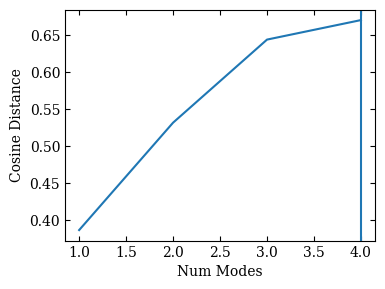

In [7]:
model = model_6 # To plot this model

plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

ax.plot(model.num_modes_, model.errors_)
ax.axvline(4)
ax.set_xlabel('Num Modes')
ax.set_ylabel('Cosine Distance')

In [8]:
model_4.fit_f(x, len(t), sr, 4)
model_2.fit_f(x, len(t), sr, 2)
model_2_30.fit_f(x, len(t), sr, 2)
model_6.fit_f(x, len(t), sr, 4)

In [9]:
def get_colors(freq, f0):
    assert len(freq)==len(f0)

    colors = []
    freq_actual = np.array([4,17,30])
    f0_actual = np.array([1,0])
    for i in range(len(freq)):
        idx_freq = np.argmin(np.abs((freq[i] - freq_actual)))
        idx_f0 = np.argmin(np.abs((f0[i] - f0_actual)))
        if freq_actual[idx_freq]==4 and f0_actual[idx_f0]==1:
            colors.append('blue')
        elif freq_actual[idx_freq]==30 and f0_actual[idx_f0]==1:
            colors.append('blue')
        elif freq_actual[idx_freq]==30 and f0_actual[idx_f0]==0:
            colors.append('green')
        elif freq_actual[idx_freq]==17 and f0_actual[idx_f0]==0:
            colors.append('orange')
        else:
            print(i,freq_actual[idx_freq], f0_actual[idx_f0])
    return(np.array(colors))

Text(0, 0.5, 'True f(t)')

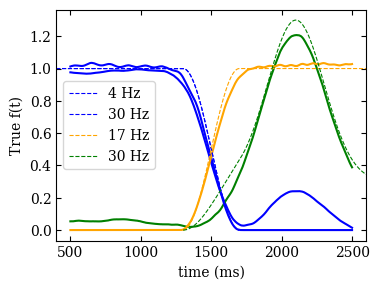

In [10]:
model = model_6 #to plot

plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

colors = get_colors(model.freq_mean_, model.f_hat_[:,500])
for i,f in enumerate(model.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

colors = get_colors([f1,f2,f3,f4], [F1_true[0,0], F2_true[0,0], F3_true[0,0], F4_true[0,0]])
ax.plot(t1, np.mean(F1_true, axis=0), color=colors[0], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[1], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[2], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[3], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('True f(t)')

In [11]:
mse = []
for model in [model_4, model_2, model_2_30, model_6]:
    x_rec = model.transform(x, len(t), sr)
    mse.append(np.mean((x - x_rec)**2))

opt_mse = []
for i in range(2,11):
    temp = nsdmd.optdmd.OptDMD(x, t, i)
    temp.fit(verbose=False)
    opt_mse.append(np.mean(temp.reconstruction[1]**2))

mse.append(np.min(opt_mse))
mse = np.array(mse)**0.5

opt_rank = np.arange(2,11)[np.argmin(opt_mse)]

X_dmd MSE 0.016701591772909828
X_dmd MSE 0.018181005477059413
X_dmd MSE 0.016506541370572458
X_dmd MSE 0.01864490683418546
X_dmd MSE 0.01864626095386786
X_dmd MSE 0.018349264398849183
X_dmd MSE 0.017732983370636717
X_dmd MSE 0.01793509141502858
X_dmd MSE 0.018145102098829625


X_dmd MSE 0.016506541370572458


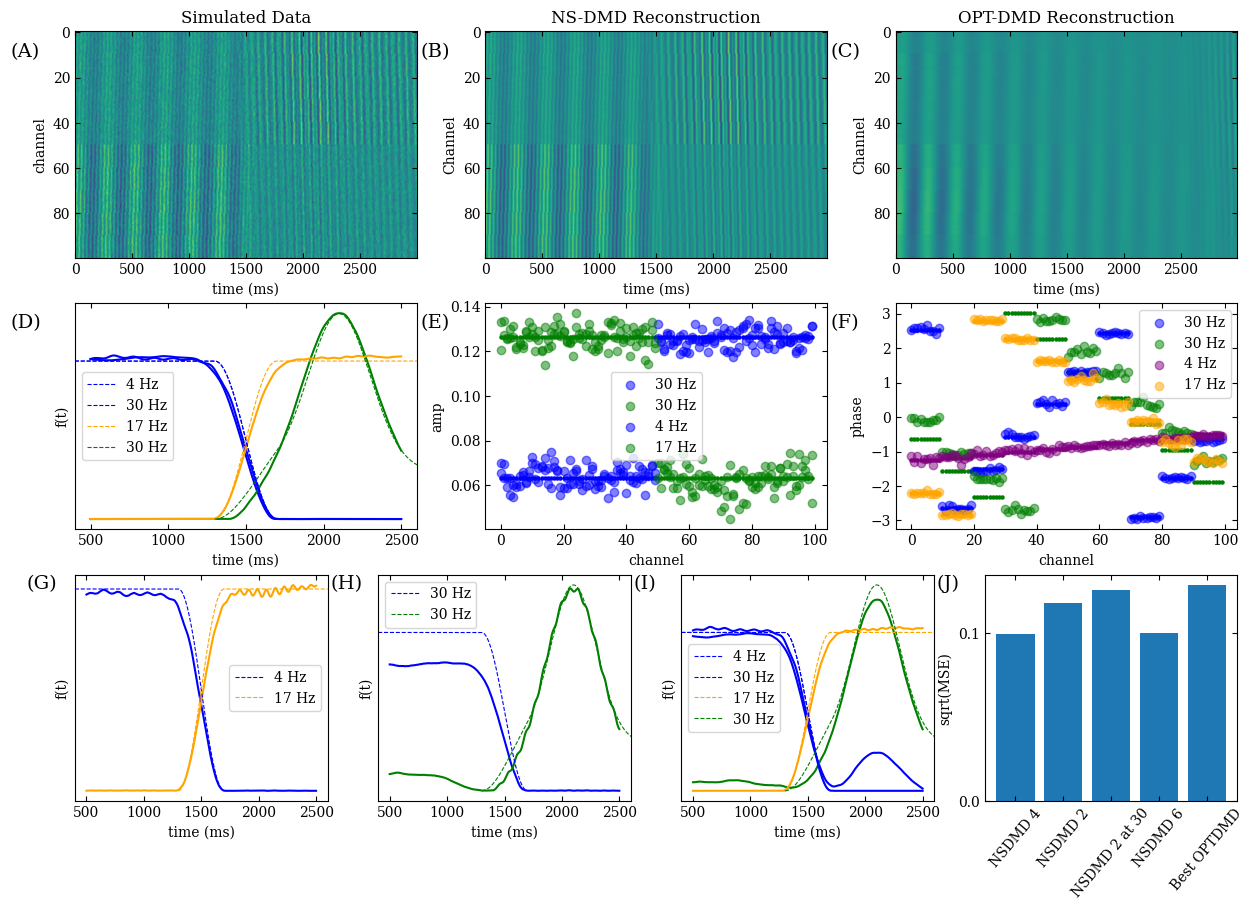

In [20]:
#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(15,10))

#Data
ax = fig.add_subplot(331)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(x, aspect='auto', vmin=-0.5, vmax=0.5)
# cbar = fig.colorbar(cax)
# cbar.set_label('Amp (A.U.)', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('channel')
ax.set_title('Simulated Data')
ax.text(-0.19, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Reconstruction Error
ax = fig.add_subplot(332)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

x_rec = model_4.transform(x, len(t), sr)
ax.imshow(x_rec, aspect='auto', vmin=-0.5, vmax=0.5)
ax.set_title('NS-DMD Reconstruction')
ax.set_xlabel('time (ms)')
ax.set_ylabel('Channel')
ax.text(-0.19, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#OPT-DMD Reconstruction
ax = fig.add_subplot(333)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
temp = nsdmd.optdmd.OptDMD(x, t, opt_rank)
temp.fit(verbose=False)
x_rec = np.real(temp.reconstruction[0])
ax.imshow(x_rec, aspect='auto', vmin=-0.5, vmax=0.5)
ax.set_title('OPT-DMD Reconstruction')
ax.set_xlabel('time (ms)')
ax.set_ylabel('Channel')
ax.text(-0.19, 0.95, '(C)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#4 Mode f(t)
ax = fig.add_subplot(334)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = get_colors(model_4.freq_mean_, model_4.f_hat_[:,500])
for i,f in enumerate(model_4.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

colors = get_colors([f1,f2,f3,f4], [F1_true[0,0], F2_true[0,0], F3_true[0,0], F4_true[0,0]])
ax.plot(t1, np.mean(F1_true, axis=0), color=colors[0], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[1], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[2], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[3], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('f(t)')
ax.set_yticks([])
ax.text(-0.19, 0.95, '(D)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#4 mode phi amp
ax = fig.add_subplot(335)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

phi_a1 = np.hstack([i*np.ones(50) for i in [1,2]])
phi_a2 = np.hstack([i*np.ones(50) for i in [2,1]])
phi_a1 /= np.sum(phi_a1**2)**0.5
phi_a2 /= np.sum(phi_a2**2)**0.5

ax.scatter(np.arange(len(phi_a1)), phi_a1, color='blue', s=5)
ax.scatter(np.arange(len(phi_a2)), phi_a2, color='green', s=5)

_, phi = model_4.get_freq_and_phi(len(t), sr)
idx = model_4.f_hat_ > np.mean(model_4.f_hat_, axis=1)[:,None]
phi_a = np.array([np.mean(np.abs(phi[i,idx[i]]), axis=0) for i in range(4)])

colors = get_colors(model_4.freq_mean_, model_4.f_hat_[:,500])
colors[colors=='orange'] = 'green'
for i in range(4):
    ax.scatter(np.arange(100), phi_a[i], color=colors[i], alpha=0.5, label=str(round(model_4.freq_mean_[i]))+' Hz')
ax.legend()
ax.set_xlabel('channel')
ax.set_ylabel('amp')

ax.text(-0.19, 0.95, '(E)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#4 mode phi phase
ax = fig.add_subplot(336)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
phi_p = np.array([
    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),
    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),
    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),
    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(30,-10,10)]])
])

ax.scatter(np.arange(100), ((2 * np.pi * f1) * (phi_p[0] + len(t1)-t1[0]) / sr + np.pi) % (2*np.pi) - np.pi, color='purple', s=5)
ax.scatter(np.arange(100), ((2 * np.pi * f2) * (phi_p[1] + len(t2)-t2[0]) / sr + np.pi) % (2*np.pi) - np.pi, color='blue', s=5)
ax.scatter(np.arange(100), ((2 * np.pi * f3) * (phi_p[2] + len(t3)-t3[0]) / sr + np.pi) % (2*np.pi) - np.pi, color='orange', s=5)
ax.scatter(np.arange(100), ((2 * np.pi * f4) * (phi_p[3] + len(t4)-t4[0]) / sr + np.pi) % (2*np.pi) - np.pi, color='green', s=5)

_, phi = model_4.get_freq_and_phi(len(t), sr)
idx = model_4.f_hat_ > np.mean(model_4.f_hat_, axis=1)[:,None]
phi_p2 = np.array([scipy.stats.circmean(np.angle(phi[i,idx[i]]), axis=0,low=-np.pi,high=np.pi) for i in range(4)])

colors = get_colors(model_4.freq_mean_, model_4.f_hat_[:,500])
idx = np.argmin(np.abs(model_4.freq_mean_-4))
colors[idx] = 'purple'
for i in range(0,4):
    ax.scatter(np.arange(100), phi_p2[i], color=colors[i], alpha=0.5, label=str(round(model_4.freq_mean_[i]))+' Hz')
ax.legend()
ax.set_xlabel('channel')
ax.set_ylabel('phase')
ax.text(-0.19, 0.95, '(F)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#2 Mode f(t)
ax = fig.add_subplot(349)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = get_colors(model_2.freq_mean_, model_2.f_hat_[:,500])
for i,f in enumerate(model_2.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

colors = get_colors([f1,f3], [F1_true[0,0], F3_true[0,0]])
ax.plot(t1, np.mean(F1_true, axis=0), color=colors[0], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[1], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('f(t)')
ax.set_yticks([])
ax.text(-0.19, 1, '(G)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# 2 Mode 30 Hz f(t)
ax = fig.add_subplot(3,4,10)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = get_colors(model_2_30.freq_mean_, model_2_30.f_hat_[:,500])
for i,f in enumerate(model_2_30.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

colors = get_colors([f2,f4], [F2_true[0,0], F4_true[0,0]])
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[1], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('f(t)')
ax.set_yticks([])
ax.text(-0.19, 1, '(H)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# #6 Mode f(t)
ax = fig.add_subplot(3,4,11)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = get_colors(model_6.freq_mean_, model_6.f_hat_[:,500])
for i,f in enumerate(model_6.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

colors = get_colors([f1,f2,f3,f4], [F1_true[0,0], F2_true[0,0], F3_true[0,0], F4_true[0,0]])
ax.plot(t1, np.mean(F1_true, axis=0), color=colors[0], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[1], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[2], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[3], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('f(t)')
ax.set_yticks([])
ax.text(-0.19, 1, '(I)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# #Mean squared error
ax = fig.add_subplot(3,4,12)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
ax.bar(np.arange(5), mse)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(['NSDMD 4', 'NSDMD 2', 'NSDMD 2 at 30', 'NSDMD 6', 'Best OPTDMD'], rotation=50)
ax.set_ylabel('sqrt(MSE)')
ax.set_yticks([0,0.1])
ax.text(-0.19, 1, '(J)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.savefig('figs/two_net_all.svg', bbox_inches='tight')

plt.show()